# Import bibliothèques

In [1]:
import configparser
import pandas

from PIL import Image
import io
import os
import numpy as np

import boto3

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, DataType, FloatType
from pyspark.sql.functions import udf

# Taches machine learning
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA

import matplotlib.pyplot as plt
plt.style.use('seaborn')

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model

Using TensorFlow backend.
C:\Users\S053567\Anaconda3\envs\OC_P08\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\S053567\Anaconda3\envs\OC_P08\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\S053567\Anaconda3\envs\OC_P08\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\S053567\Anaconda3\envs\OC_P08

In [2]:
spark

In [3]:
# pyspark --master spark://127.0.0.1:7077 --driver-memory 8g

# Récupération du profil S3

In [4]:
aws_profile = "default"

config = configparser.ConfigParser()
config.read(os.path.expanduser(".aws/credentials"))
access_id = config.get(aws_profile, "aws_access_key_id".upper()) 
access_key = config.get(aws_profile, "aws_secret_access_key".upper())

In [5]:
session = boto3.Session(
    aws_access_key_id=access_id,
    aws_secret_access_key=access_key,
)

## Test de lecture

In [6]:
s3 = session.resource('s3')
bucket = s3.Bucket("fruits-oc-p08")
obj = bucket.Object(key='sample/apple_golden_1/r0_107.jpg')
response = obj.get()
file_stream = response[u'Body']
im = Image.open(file_stream)
im = im.resize((224,224))
im_arr = np.asarray(im)

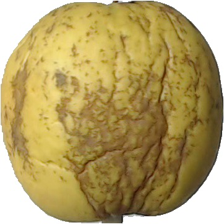

In [7]:
im

# Création SparkDataFrame a partir des données S3

## Récupération des liens

In [8]:
paths = []
for file in bucket.objects.all():
    if file.key.split('/')[0] == 'sample':
        paths.append(file.key)
    
rdd_paths = sc.parallelize(paths)
row_rdd_paths = rdd_paths.map(lambda x: Row(x))

In [9]:
images_df = spark.createDataFrame(row_rdd_paths, ['path'])

In [10]:
images_df.show(6)

+--------------------+
|                path|
+--------------------+
|sample/apple_gold...|
|sample/apple_gold...|
|sample/apple_gold...|
|sample/apple_gold...|
|sample/apple_gold...|
|sample/cabbage_wh...|
+--------------------+
only showing top 6 rows



## Récupération des categs

In [11]:
def get_categ(path):
    folder_name = path.split('/')[1]
    categ = folder_name.split('_1')[0]
    return categ

In [12]:
udf_categ = udf(get_categ, StringType())
images_df = images_df.withColumn('categ', udf_categ('path'))

In [13]:
images_df.show(6, truncate=60)

+---------------------------------+-------------+
|                             path|        categ|
+---------------------------------+-------------+
| sample/apple_golden_1/r0_107.jpg| apple_golden|
| sample/apple_golden_1/r0_171.jpg| apple_golden|
| sample/apple_golden_1/r1_147.jpg| apple_golden|
| sample/apple_golden_1/r1_175.jpg| apple_golden|
| sample/apple_golden_1/r1_239.jpg| apple_golden|
|sample/cabbage_white_1/r0_139.jpg|cabbage_white|
+---------------------------------+-------------+
only showing top 6 rows



## Récupération des images

In [14]:
def get_image(path):
    s3 = session.resource('s3')
    bucket = s3.Bucket("fruits-oc-p08")
    obj = bucket.Object(key=path)
    response = obj.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    im_resized = im.resize((20, 20))
    return np.array(im_resized).flatten().tolist()

In [15]:
len(get_image('sample/apple_golden_1/r0_107.jpg'))

1200

In [16]:
udf_image = udf(get_image)

In [17]:
images_df = images_df.withColumn('data', udf_image('path'))

In [18]:
images_df.show(6, truncate=60)

+---------------------------------+-------------+------------------------------------------------------------+
|                             path|        categ|                                                        data|
+---------------------------------+-------------+------------------------------------------------------------+
| sample/apple_golden_1/r0_107.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r0_171.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r1_147.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r1_175.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r1_239.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
|sample/cabbage_white_1/r0_139.jpg|cabbage_white|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
+

## Création des vecteurs

In [19]:
# conversion format vecteur dense
udf_vecto = udf(lambda r: Vectors.dense(r), VectorUDT())
images_df = images_df.withColumn('data', udf_vecto('data'))

## Standardisation

In [20]:
#standardisation des données
standardizer = StandardScaler(inputCol="data", outputCol="data_scale", withStd=True, withMean=True)
model_std = standardizer.fit(images_df)
images_df = model_std.transform(images_df)

In [21]:
images_df = images_df.drop('data')

# Entrainement PCA

In [22]:
pca_obj = PCA(k=100, inputCol='data_scale')
pca_model = pca_obj.fit(images_df)

Text(0, 0.5, 'Variance cumulée')

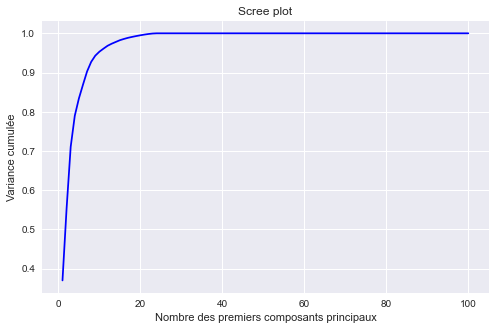

In [23]:
eVc = pca_model.explainedVariance.cumsum()
#plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(8,5))
plt.plot(range(1,len(eVc)+1), eVc, color='b', linestyle='-')
plt.title('Scree plot')
plt.xlabel('Nombre des premiers composants principaux')
plt.ylabel('Variance cumulée')

### On prend 20 composantes principales

In [24]:
pca_obj = PCA(k=20, inputCol='data_scale', outputCol='pca_features_classic')
pca_model = pca_obj.fit(images_df)

In [25]:
images_df = pca_model.transform(images_df)

In [26]:
images_df.show(6)

+--------------------+-------------+--------------------+--------------------+
|                path|        categ|          data_scale|pca_features_classic|
+--------------------+-------------+--------------------+--------------------+
|sample/apple_gold...| apple_golden|[0.29727137307215...|[4.98322515727135...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|[9.61064370313451...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|[6.13758904996987...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|[7.46652431865648...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|[8.93427882146846...|
|sample/cabbage_wh...|cabbage_white|[0.29727137307215...|[6.35674010172881...|
+--------------------+-------------+--------------------+--------------------+
only showing top 6 rows



In [27]:
images_df = images_df.drop('data_scale')

# Extraction des features avec VGG16

In [28]:
def get_vgg16_features(path):
    virgin_vgg16 = VGG16()
    model_vgg16 = Model(inputs=virgin_vgg16.inputs, outputs=virgin_vgg16.layers[-2].output)
    s3 = session.resource('s3')
    bucket = s3.Bucket("fruits-oc-p08")
    obj = bucket.Object(key=path)
    response = obj.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    im = im.resize((224, 224))
    im = img_to_array(im)
    im = im.reshape(1, 224, 224, 3)
    im = preprocess_input(im)
    features = model_vgg16.predict(im).ravel().tolist()
    return features

In [29]:
udf_vgg_features = udf(get_vgg16_features)

In [30]:
images_df = images_df.withColumn('vgg_features', udf_vgg_features('path'))

In [31]:
images_df.show(6)

+--------------------+-------------+--------------------+--------------------+
|                path|        categ|pca_features_classic|        vgg_features|
+--------------------+-------------+--------------------+--------------------+
|sample/apple_gold...| apple_golden|[4.98322515727135...|[0.0, 0.0, 0.0, 0...|
|sample/apple_gold...| apple_golden|[9.61064370313451...|[0.0, 0.0, 0.0, 0...|
|sample/apple_gold...| apple_golden|[6.13758904996987...|[0.0, 0.0, 0.0, 0...|
|sample/apple_gold...| apple_golden|[7.46652431865648...|[0.0, 0.0, 1.0020...|
|sample/apple_gold...| apple_golden|[8.93427882146846...|[0.0, 0.0, 0.0, 0...|
|sample/cabbage_wh...|cabbage_white|[6.35674010172881...|[0.0, 0.0, 0.0, 0...|
+--------------------+-------------+--------------------+--------------------+
only showing top 6 rows



In [32]:
udf_vecto = udf(lambda r: Vectors.dense(r), VectorUDT())

In [33]:
images_df = images_df.withColumn('vgg_features', udf_vecto('vgg_features'))

In [34]:
standardizer = StandardScaler(inputCol="vgg_features", outputCol="vgg_features_scale", withStd=True, withMean=True)
model_std = standardizer.fit(images_df)
images_df = model_std.transform(images_df)

In [35]:
images_df.show(6)

+--------------------+-------------+--------------------+--------------------+--------------------+
|                path|        categ|pca_features_classic|        vgg_features|  vgg_features_scale|
+--------------------+-------------+--------------------+--------------------+--------------------+
|sample/apple_gold...| apple_golden|[4.98322515727135...|[0.0,0.0,0.0,0.0,...|[0.0,-0.425535354...|
|sample/apple_gold...| apple_golden|[9.61064370313451...|[0.0,0.0,0.0,0.0,...|[0.0,-0.425535354...|
|sample/apple_gold...| apple_golden|[6.13758904996987...|[0.0,0.0,0.0,0.0,...|[0.0,-0.425535354...|
|sample/apple_gold...| apple_golden|[7.46652431865648...|[0.0,0.0,1.002059...|[0.0,-0.425535354...|
|sample/apple_gold...| apple_golden|[8.93427882146846...|[0.0,0.0,0.0,0.0,...|[0.0,-0.425535354...|
|sample/cabbage_wh...|cabbage_white|[6.35674010172881...|[0.0,0.0,0.0,0.59...|[0.0,-0.425535354...|
+--------------------+-------------+--------------------+--------------------+--------------------+


In [36]:
images_df = images_df.drop('vgg_features')

In [37]:
pca_obj = PCA(k=100, inputCol='vgg_features_scale')
pca_model = pca_obj.fit(images_df)

Text(0, 0.5, 'Variance cumulée')

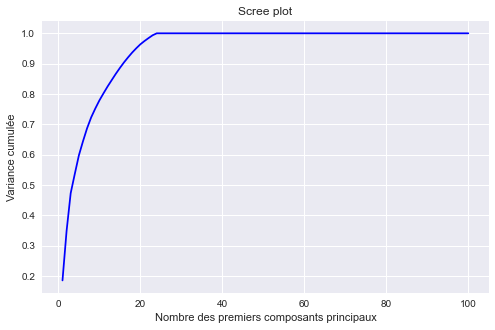

In [38]:
eVc = pca_model.explainedVariance.cumsum()
#plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(8,5))
plt.plot(range(1,len(eVc)+1), eVc, color='b', linestyle='-')
plt.title('Scree plot')
plt.xlabel('Nombre des premiers composants principaux')
plt.ylabel('Variance cumulée')

### On prend 24 composantes principales

In [39]:
pca_obj = PCA(k=24, inputCol='vgg_features_scale', outputCol='pca_features_vgg')
pca_model = pca_obj.fit(images_df)

In [40]:
images_df = pca_model.transform(images_df)

In [41]:
images_df.show(6)

+--------------------+-------------+--------------------+--------------------+--------------------+
|                path|        categ|pca_features_classic|  vgg_features_scale|    pca_features_vgg|
+--------------------+-------------+--------------------+--------------------+--------------------+
|sample/apple_gold...| apple_golden|[4.98322515727135...|[0.0,-0.425535354...|[-3.8247194776895...|
|sample/apple_gold...| apple_golden|[9.61064370313451...|[0.0,-0.425535354...|[-2.4402221520122...|
|sample/apple_gold...| apple_golden|[6.13758904996987...|[0.0,-0.425535354...|[4.11065318320529...|
|sample/apple_gold...| apple_golden|[7.46652431865648...|[0.0,-0.425535354...|[4.94032415879324...|
|sample/apple_gold...| apple_golden|[8.93427882146846...|[0.0,-0.425535354...|[2.42931093489876...|
|sample/cabbage_wh...|cabbage_white|[6.35674010172881...|[0.0,-0.425535354...|[-29.997279421664...|
+--------------------+-------------+--------------------+--------------------+--------------------+


In [42]:
images_df_pandas = images_df.toPandas()

In [46]:
from io import StringIO

In [48]:
csv_obj = StringIO()
images_df_pandas.to_csv(csv_obj)
s3.Object('fruits-oc-p08', "results/results_sample_local_1.csv").put(Body=csv_obj.getvalue())

{'ResponseMetadata': {'RequestId': 'RJTZF9P05JF5SDGB',
  'HostId': 'UlpRSiy8oLykBt4o4TjZsDxfdMY0Aon8fUIl6owNDLsxJywfgYGbDVuH7V+V2q0KCy5U9pMgnVE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'UlpRSiy8oLykBt4o4TjZsDxfdMY0Aon8fUIl6owNDLsxJywfgYGbDVuH7V+V2q0KCy5U9pMgnVE=',
   'x-amz-request-id': 'RJTZF9P05JF5SDGB',
   'date': 'Wed, 02 Mar 2022 08:42:25 GMT',
   'etag': '"952a38e02f32c5a5d5f7aa40fee23786"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"952a38e02f32c5a5d5f7aa40fee23786"'}

In [49]:
images_df_pandas

,path,categ,pca_features_classic,vgg_features_scale,pca_features_vgg
0,sample/apple_golden_1/r0_107.jpg,apple_golden,"[4.983225157271351, 2.998124013513851, -13.219...","[0.0, -0.4255353542048959, -0.4189828341756907...","[-3.8247194776895452, -14.344132411245436, 14...."
1,sample/apple_golden_1/r0_171.jpg,apple_golden,"[9.61064370313451, -1.2338946724610755, -21.53...","[0.0, -0.4255353542048959, -0.4189828341756907...","[-2.4402221520122644, -18.489174136844504, 12...."
2,sample/apple_golden_1/r1_147.jpg,apple_golden,"[6.137589049969879, -0.12308755848611984, -12....","[0.0, -0.4255353542048959, -0.4189828341756907...","[4.11065318320529, -16.737005855901835, 17.754..."
3,sample/apple_golden_1/r1_175.jpg,apple_golden,"[7.466524318656489, 1.7919673145063892, -19.34...","[0.0, -0.4255353542048959, 1.9590561012733818,...","[4.940324158793245, -16.94951440035451, 17.182..."
4,sample/apple_golden_1/r1_239.jpg,apple_golden,"[8.93427882146846, 1.248612152546039, -17.1469...","[0.0, -0.4255353542048959, -0.4189828341756907...","[2.4293109348987647, -18.307337955467336, 6.90..."
5,sample/cabbage_white_1/r0_139.jpg,cabbage_white,"[6.35674010172881, -8.748284267485557, -9.5116...","[0.0, -0.4255353542048959, -0.4189828341756907...","[-29.99727942166436, 22.716796993357352, 18.35..."
6,sample/cabbage_white_1/r0_15.jpg,cabbage_white,"[9.79369732928438, -8.59407456074032, -12.9782...","[0.0, -0.4255353542048959, -0.4189828341756907...","[-26.947976180034864, 27.275713634380722, 15.8..."
7,sample/cabbage_white_1/r0_159.jpg,cabbage_white,"[8.119063502459555, -7.494255287809149, -12.74...","[0.0, -0.4255353542048959, -0.4189828341756907...","[-31.69133316652998, 29.39039946998507, 17.399..."
8,sample/cabbage_white_1/r0_63.jpg,cabbage_white,"[8.11798925209421, -8.159591282814786, -8.7228...","[0.0, -0.4255353542048959, -0.4189828341756907...","[-30.346915563116205, 27.305044663039567, 17.9..."
9,sample/cabbage_white_1/r0_91.jpg,cabbage_white,"[8.959357982202029, -7.77202730378071, -12.443...","[0.0, -0.4255353542048959, -0.4189828341756907...","[-28.562123522900972, 25.49870009801223, 16.68..."
